In [1]:
cd /Users/lisa2021/Desktop/mqmtest_final/

/Users/lisa2021/Desktop/mqmtest_final


In [2]:
result_path = 'fewshot/fewshot1.csv'

from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from util.evaluation import extract_json, handle_no_error_segment, get_segment_score, extract_json_llama,f1
from util.evaluation import extract_output_error_list,get_recall, get_precision,extract_json,get_severity_and_type_from_recall,get_severity_and_type_from_precision
from util.analysis import mqm_scoring, gold_list_omission
from util.comet_data import calculate_quality_score
from util.evaluation_few_shot import extract_output_error_list_few_shot
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
import numpy as np
import ast
import pandas as pd
import json
from openai import OpenAI
dev_df = pd.read_csv('data/prompt_dev/prompt_dev.csv', index_col=0)
pd.set_option('display.max_colwidth', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# # https://github.com/openai/openai-cookbook/blob/main/examples/How_to_format_inputs_to_ChatGPT_models.ipynb
# import json
# def call_gpt_two_shot(cn,en, model = 'gpt-4o', seed = 240425, max_tokens = 1024,temperature = 1, top_p = 1,frequency_penalty =0, presence_penalty= 0):
#     """
#     cn - en 2 shot fluency - minor - comma;
#     """

#     client = OpenAI()
#     response = client.chat.completions.create(
#     model= model,
#     seed = seed,
#     max_tokens=max_tokens,
#     temperature = temperature,
#     top_p= top_p,
#     frequency_penalty = frequency_penalty,
#     presence_penalty = presence_penalty,
#     messages=[
#         {"role": "system", "content": "You are a professional Chinese-English translator."},
#         {"role": "user", "content": """Your task is to identify translation errors from the pair of source Chinese sentence and the target English sentence.
#     Please identify a maximum of 5 errors, assigning an error type and a severity scale from 1 (least severe) to 5 (most severve) using the MQM annotation scheme.
#     Please consider the following criteria for identifying errors:
#     1. Accuracy: when target translation does not accurately represent the source
#     2. Omission: when the target translation is missing content present in the source text. Identify if any information has been omitted.
#     3. Fluency: issue with punctuation, spelling, grammar, register, inconsistency
#     4. Style: when the translation is grammatically correct but uses unnatural or awkward language.
#     5. Terminlogy: inappropriate or inconsistent use of terms.
#     6. Locale convention: issues with formatting

#     Please provide the output in JSON format including the following keys for each error:

#      [{"error type": (values: accuracy, omission, style, fluency, terminology, locale convention, other),
#      "error span index": (start and end index of the marked text in the target sentence),
#      "marked text":(the identified error in the target sentence),
#      "severity": (1-5)
#      "explanation":}, {},{}]"""},
#         {"role": "assistant","content": "Ok, I am ready. Please provide me with a Chinese source sentence and its English target translation."},
#         {"role": "user", "content": "Source: 产品特价的时候购买，价格不低，看评论也是很不错的产品。; Target: I bought it when the product was on sale, the price is not low, and it is also a very good product after reading the reviews."},
#         {"role": "assistant", "content": """[{"error type": "Fluency", "severity": 2, "marked text": ",", "error span index": {"start": 9, "end": 9},
#          "explanation": "Using a comma to separate the independent clauses in this case creates a comma splice error."}]"""},
#         {"role": "user", "content": "Source: 用了很久，除了低音出不来，总体还不错。; Target: I tried to use it for a long time, but all sounded good except for the bass."},
#         {"role": "assistant", "content":"""[{"error type": "Accuracy", "severity": 4, "marked text": "tried to", "error span index": {"start": 1, "end": 2},"explanation": "The source text suggests using something for a long time, it does not imply 'tried to'."},
#                                             {"error type": "Omission", "severity": 4, "marked text": "出不来", "error span index": {"start": 10, "end": 10}, "explanation":"The target translation misses the specific detail that the bass 'could not come out' (出不来), indicating it was non-functional, which is a key aspect of the source text." }]"""},
#         {"role": "user", "content": f"Source: {cn}; Target: {en}"}
#         ])

#     result = response.choices[0].message.content
#     fingerprint = response.system_fingerprint

#     print('response.model_dump_json():')
#     print(json.dumps(json.loads(response.model_dump_json()), indent=4))

#     return result, fingerprint



# def calling(x,y):

#     result, fingerprint = call_gpt_two_shot(x,y,model = "gpt-4o" ,seed = 240425, max_tokens = 1024,temperature = 1, top_p = 1,frequency_penalty =0, presence_penalty= 0)
#     return result,fingerprint

# gpt_40_output_fingerprint = dev_df.apply(lambda row: calling(row['source'], row['target']), axis = 1, result_type='expand')
# result_40 = pd.concat([dev_df, gpt_40_output_fingerprint], axis = 1)
# result_40.rename(columns={0:'gpt 4.0 output', 1:'fingerprint'},inplace=True)
# result_40.to_csv(result_path)

# Analysis

In [4]:
# column transformation
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(result_path, index_col='Unnamed: 0')

df['parse_gold_error_list'] = df['parse_gold_error_list'].apply(lambda x: ast.literal_eval(x))
def re_index_omission(x):
    for ind, error in enumerate(x):
        if error[0] == 'Omission':
            new = error
            new[3]['start'] = error[3]['start'] - 3
            new[3]['end'] = error[3]['end'] - 2
            x[ind] = new
    return x
df['parse_gold_error_list'] = df['parse_gold_error_list'].apply(re_index_omission)


df['f_json_extract'] = df['gpt 4.0 output'].apply(extract_json)
df = df[df['f_json_extract'].notna()]
# filter out invalid json


df['2_parse_output_error_list'] = df.apply(lambda x: extract_output_error_list_few_shot(x['f_json_extract'], x['target'], x['source']), axis = 1)

df = df[df['2_parse_output_error_list'].notna()]
print(len(df))
df['3_system_error_num'] = df['2_parse_output_error_list'].apply(lambda x: len(x))
print(df['3_system_error_num'].value_counts())
df['f_gold_no_error_segment'] = df.apply(lambda x: handle_no_error_segment(x['gold_error_num'], x['3_system_error_num']), axis = 1)



df['4_recall'] = df.apply(lambda x: get_recall(x['parse_gold_error_list'], x['2_parse_output_error_list'], x['f_gold_no_error_segment']), axis= 1)
df['5_precision'] = df.apply(lambda x: get_precision(x['parse_gold_error_list'], x['2_parse_output_error_list'], x['f_gold_no_error_segment']), axis= 1)

print(df.columns)

display_columnls = ['source', 'target', 'joined omission', 'gpt 4.0 output','gold_error_num', 'fingerprint', 'parse_gold_error_list',
        '2_parse_output_error_list', '3_system_error_num', 'gold_mqm_score',
        '4_recall', '5_precision','quality_score']
df = df[display_columnls]

df['segment_recall'] = df['4_recall'].apply(get_segment_score)
df['segment_precision'] = df['5_precision'].apply(get_segment_score)

df['f1'] = df.apply(lambda x: f1(x['segment_recall'],x['segment_precision']),axis = 1)
df['6_gpt_4.0_mqm_score'] = df['2_parse_output_error_list'].apply(mqm_scoring)
df['system_mqm_Minus_gold_mqm'] = df.apply(lambda x: x['6_gpt_4.0_mqm_score'] - x['gold_mqm_score'], axis = 1)
df['system_quality_score'] = df.apply(lambda x: calculate_quality_score(x['2_parse_output_error_list'],x['target']),axis = 1)
print(len(df))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/86/dkx02css7094lzgc17d9_9n00000gn/T/jieba.cache
Loading model cost 0.429 seconds.
Prefix dict has been built successfully.


909
3_system_error_num
2    290
3    228
4    171
1    143
5     65
0     10
6      2
Name: count, dtype: int64
Index(['system', 'doc', 'docSegId', 'globalSegId', 'rater', 'source', 'target',
       'metadata', 'joined mqm', 'joined omission', 'mqm_from_re_search',
       'parse_gold_error_list', 'gold_error_num', 'token count',
       'quality_score', 'gold_mqm_score', 'gpt 4.0 output', 'fingerprint',
       'f_json_extract', '2_parse_output_error_list', '3_system_error_num',
       'f_gold_no_error_segment', '4_recall', '5_precision'],
      dtype='object')
909


# System level

## Error sum, error length

Gold error sum:  1419
System error sum:  2428
6


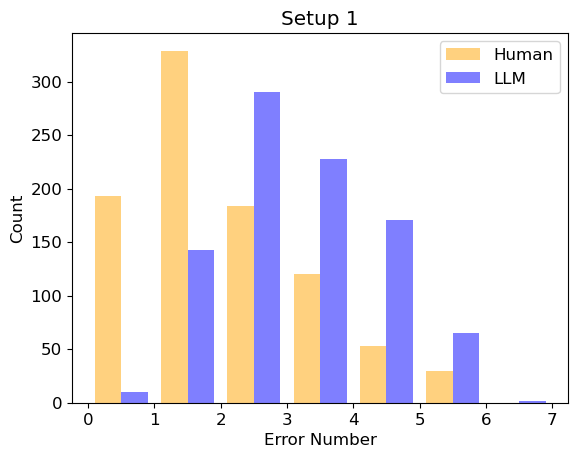

In [33]:
from util.plotting import hist_plot
# system sum
import matplotlib.pyplot as plt
print('Gold error sum: ', df['gold_error_num'].sum())
plt.rcParams.update({'font.size': 12})
print('System error sum: ', df['3_system_error_num'].sum())
hist_plot(df['gold_error_num'], df['3_system_error_num'] , 'Setup 1')

In [6]:
tokens_g = []
annotation_length_gold = []
mqm_n_g = 0
for mqms in df['parse_gold_error_list']:
    for mqm in mqms:
        mqm_n_g += 1
        mqm_t = word_tokenize(mqm[2])
        annotation_length_gold.append(len(mqm_t))
        tokens_g.extend(mqm_t)
characters_g = sum([len(token) for token in tokens_g])
print('characters in total: ', characters_g / mqm_n_g)
print('tokens in total: ',len(tokens_g))
print('errors in total: ', mqm_n_g)
print('GOLD: token in total / error in total:', len(tokens_g) / mqm_n_g)

# calculating character average for each error span and token average
# how many tokens per annotation?
from nltk.tokenize import word_tokenize
tokens_s = []
annotation_length_system = [] # for length plotting
mqm_n_s = 0
for mqms in df['2_parse_output_error_list']:
    for mqm in mqms:
        mqm_n_s += 1
        mqm_t = word_tokenize(mqm[2])
        annotation_length_system.append(len(mqm_t))
        tokens_s.extend(mqm_t)
characters_s = sum([len(token) for token in tokens_s])
print('characters in total: ', characters_s / mqm_n_s)
print('tokens in total: ',len(tokens_s))
print('errors in total: ', mqm_n_s)
print('SYSTEM: token in total / error in total:', len(tokens_s) / mqm_n_s)

characters in total:  18.51726568005638
tokens in total:  5660
errors in total:  1419
GOLD: token in total / error in total: 3.988724453840733
characters in total:  18.16144975288303
tokens in total:  9414
errors in total:  2428
SYSTEM: token in total / error in total: 3.8772652388797364


## Severity, Error type

In [7]:
system_severity = {}
system_severity['major'] = 0
system_severity['minor'] = 0

gold_severity = {}
gold_severity['Major'] = 0
gold_severity['Minor'] = 0

for g in df['parse_gold_error_list']:
    for gg in g:
        if gg[1] == 'Major':
            gold_severity['Major'] += 1
        if gg[1] == 'Minor':
            gold_severity['Minor'] +=1
print(gold_severity)
for s in df['2_parse_output_error_list']:
    for ss in s:
        if ss[1] == 'major':
            system_severity['major'] += 1
        if ss[1] == 'minor':
            system_severity['minor'] +=1

print(system_severity)

from collections import Counter

gold_error_type = []
system_error_type = []


for g in df['parse_gold_error_list']:
    for gg in g:
        gold_error_type.append(gg[0])


for s in df['2_parse_output_error_list']:
    for ss in s:
        system_error_type.append(ss[0])
print(len(gold_error_type),Counter(gold_error_type))
print(len(system_error_type),Counter(system_error_type))

{'Major': 305, 'Minor': 1114}
{'major': 354, 'minor': 2074}
1419 Counter({'Style': 515, 'Accuracy': 433, 'Fluency': 357, 'Omission': 79, 'Terminology': 24, 'Locale Convention': 11})
2428 Counter({'fluency': 733, 'accuracy': 652, 'style': 479, 'terminology': 283, 'locale convention': 160, 'omission': 111, 'grammar': 3, 'consistency': 2, 'terminlogy': 1, 'redundancy': 1, 'punctuation': 1, 'case': 1, 'machinery': 1})


# Recall

In [8]:
df_recall = df[df['4_recall'].apply(lambda x: isinstance(x, list))]
severity_error_type_r = df_recall.apply(lambda x: get_severity_and_type_from_recall(x['parse_gold_error_list'], x['2_parse_output_error_list']), axis = 1, result_type='expand')

df_recall = pd.concat([df_recall, severity_error_type_r], axis = 1)
df_recall.rename(columns = {0:'error_type', 1:'severity'},inplace= True)

gold_error_type_r = []
system_error_type_r = []
for x in df_recall['error_type']:
    for xx in x:
        gold_error_type_r.append(xx[0].lower())
        system_error_type_r.append(xx[1])

gold_severity_r = []
system_severity_r = []
for x in df_recall['severity']:
    for xx in x:
        gold_severity_r.append(xx[0].lower())
        system_severity_r.append(xx[1])

all_recalls = []
for recall_list in df_recall['4_recall']:
    all_recalls.extend(recall_list)
r = sum(all_recalls) / len(all_recalls)
print(r)

0.6581068005411903


                   precision    recall  f1-score   support

         accuracy       0.51      0.53      0.52       339
            style       0.49      0.24      0.32       380
          fluency       0.28      0.39      0.33       200
      terminology       0.04      0.25      0.07        16
locale convention       0.00      0.00      0.00         7
         omission       1.00      1.00      1.00         7

        micro avg       0.38      0.38      0.38       949
        macro avg       0.39      0.40      0.37       949
     weighted avg       0.45      0.38      0.39       949

[[181  53  72  28   4   0]
 [109  90 125  41  13   0]
 [ 51  40  78  21   9   0]
 [  8   0   3   4   1   0]
 [  6   0   0   1   0   0]
 [  0   0   0   0   0   7]]


Text(0.5, 0.98, 'GPT-4o: Error type confusion matrix')

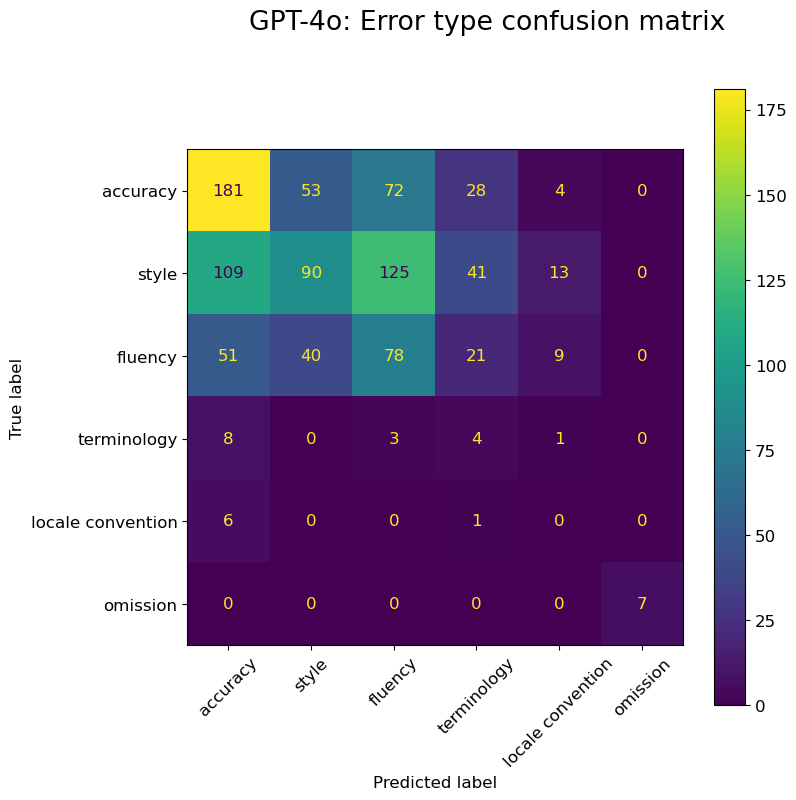

In [9]:
import matplotlib.pyplot as plt
labels = ['accuracy', 'style', 'fluency', 'terminology', 'locale convention','omission']

print(classification_report(gold_error_type_r, system_error_type_r,labels=labels))

cm = confusion_matrix(gold_error_type_r, system_error_type_r,labels = labels )
print(cm)

disp = ConfusionMatrixDisplay.from_predictions(gold_error_type_r,system_error_type_r,labels=labels)
#(confusion_matrix=cm, display_labels= labels)


fig = disp.figure_
fig.set_figwidth(8)
fig.set_figheight(8)
fig.set_label('test')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 16})
fig.suptitle('GPT-4o: Error type confusion matrix')

[[114 123]
 [130 582]]


Text(0.5, 0.98, 'GPT 4o: Severity confusion matrix')

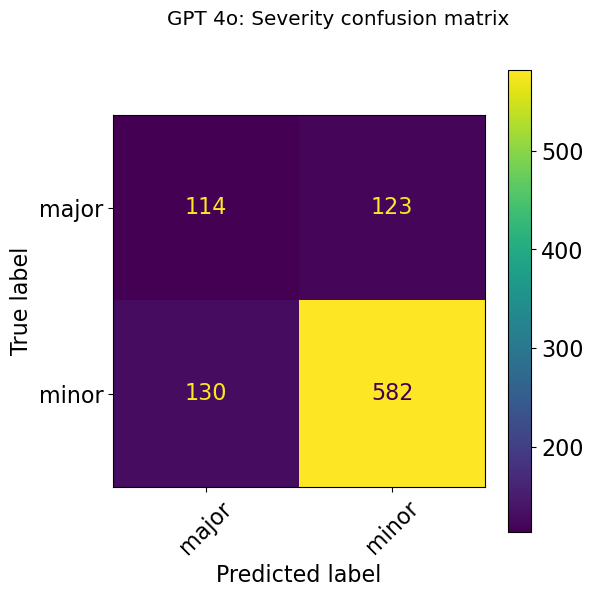

In [10]:
labels = ['major','minor']
cm = confusion_matrix(gold_severity_r, system_severity_r,labels = labels )
print(cm)

disp = ConfusionMatrixDisplay.from_predictions(gold_severity_r,system_severity_r,labels=labels)

fig = disp.figure_
fig.set_figwidth(6)
fig.set_figheight(6)
fig.set_label('test')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 12})
fig.suptitle('GPT 4o: Severity confusion matrix')

In [11]:
print(classification_report(gold_severity_r, system_severity_r,labels=labels))

              precision    recall  f1-score   support

       major       0.47      0.48      0.47       237
       minor       0.83      0.82      0.82       712

    accuracy                           0.73       949
   macro avg       0.65      0.65      0.65       949
weighted avg       0.74      0.73      0.73       949



# Precision

In [12]:
df_precision = df[df['5_precision'].apply(lambda x: isinstance(x, list))]
severity_error_type_p = df_precision.apply(lambda x: get_severity_and_type_from_precision(x['parse_gold_error_list'], x['2_parse_output_error_list']), axis = 1, result_type='expand')

df_precision = pd.concat([df_precision, severity_error_type_p], axis = 1)
df_precision.rename(columns = {0:'error_type', 1:'severity'},inplace= True)

gold_error_type_p = []
system_error_type_p = []
for x in df_precision['error_type']:
    for xx in x:
        gold_error_type_p.append(xx[1].lower())
        system_error_type_p.append(xx[0])

gold_severity_p = []
system_severity_p = []
for x in df_precision['severity']:
    for xx in x:
        gold_severity_p.append(xx[1].lower())
        system_severity_p.append(xx[0])

all_precisions = []
for pre_list in df_precision['5_precision']:
    all_precisions.extend(pre_list)
p = sum(all_precisions) / len(all_precisions)
print(p)

0.480187946755773


In [13]:
# labels = ['accuracy', 'fluency','style','terminology','locale convention']

# print(classification_report(gold_error_type_p, system_error_type_p,labels=labels))
# cm = confusion_matrix(gold_error_type_p, system_error_type_p,labels = labels )
# print(cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
# disp.plot()

In [14]:
all_precisions = []
for pre_list in df_precision['5_precision']:
    all_precisions.extend(pre_list)
p = sum(all_precisions) / len(all_precisions)
print(p)

0.480187946755773


# Overall analysis

In [15]:
print("Total segment", len(df))
print('Gold error sum: ', df['gold_error_num'].sum())
print('System error sum: ', df['3_system_error_num'].sum())
print(gold_severity)
print(system_severity)
print(len(gold_error_type),Counter(gold_error_type))
print(len(system_error_type),Counter(system_error_type))


print('Total segments:', len(df))
print()
#recall, precision
#print('Total overlap:', len(df_recall))
#total_overlap = len(df_recall)
# print('r:',round(r,3))
# print('p:',round(p,3))

#Recall
r = df['segment_recall'].mean()
p = df['segment_precision'].mean()
f1 = df['f1'].mean()
print("Total recall", round(r,3))
print("Total precision", round(p,3))
print("Total F1", round(f1,3))

print()


Total segment 909
Gold error sum:  1419
System error sum:  2428
{'Major': 305, 'Minor': 1114}
{'major': 354, 'minor': 2074}
1419 Counter({'Style': 515, 'Accuracy': 433, 'Fluency': 357, 'Omission': 79, 'Terminology': 24, 'Locale Convention': 11})
2428 Counter({'fluency': 733, 'accuracy': 652, 'style': 479, 'terminology': 283, 'locale convention': 160, 'omission': 111, 'grammar': 3, 'consistency': 2, 'terminlogy': 1, 'redundancy': 1, 'punctuation': 1, 'case': 1, 'machinery': 1})
Total segments: 909

Total recall 0.463
Total precision 0.337
Total F1 0.333



In [16]:
df['fingerprint'].value_counts()

fingerprint
fp_319be4768e    898
fp_aa87380ac5     11
Name: count, dtype: int64

In [17]:
pearson_qs = df['quality_score'].corr(df['system_quality_score'], method = 'pearson')
spearman_qs = df['quality_score'].corr(df['system_quality_score'], method = 'spearman')
print('Pearson:', round(pearson_qs,3))
print('Spearman:', round(spearman_qs,3))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Pearson: 0.492
Spearman: 0.376


In [18]:
from scipy import stats
x = df[df['quality_score'] > 0.9]['quality_score']
y = df[df['quality_score'] > 0.9]['system_quality_score']
res = stats.pearsonr(x, y)
print(res)

PearsonRResult(statistic=-0.0799481164254164, pvalue=0.08437860345492658)


In [19]:
# what errors does llm miss
#df[df['segment_recall'] == 0]

# It is possible for GPT 4o to miss errors in gold annotations in three different situations:
# \begin{itemize}
#     \item Segments have gold errors but GPT 4o didn't predict any error.
#     \item Segments have gold errors and GPT 4o predicted errors, but none overlapped.
#     \item Segments have gold errors and some are overlapped with GPT 4o output and some aren't.
# \end{itemize}
miss_error_1 = []
for ind,r in df[df['4_recall'] == 'no overlap span'].iterrows():
    for ee in r['parse_gold_error_list']:
        miss = ee[0]  + ee[1] #+ ee[2]
        miss_error_1.append(miss)

miss_error_2 = []
for ind,r in df[df['4_recall'] == 'gold not system 0'].iterrows():
    for ee in r['parse_gold_error_list']:
        miss = ee[0]  + ee[1] #+ ee[2]
        miss_error_2.append(miss)

miss_error_3 = []
for ind, r in df[df['4_recall'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['4_recall']):
        if rv == 0:
            miss = r['parse_gold_error_list'][r_ind][0]  + r['parse_gold_error_list'][r_ind][1] #+ ' '+  r['parse_gold_error_list'][r_ind][2]
            miss_error_3.append(miss)

Counter(miss_error_1 + miss_error_2 + miss_error_3)

Counter({'FluencyMinor': 157,
         'StyleMinor': 131,
         'AccuracyMinor': 74,
         'OmissionMajor': 41,
         'OmissionMinor': 31,
         'AccuracyMajor': 20,
         'TerminologyMinor': 5,
         'StyleMajor': 4,
         'Locale ConventionMinor': 4,
         'TerminologyMajor': 3})

In [20]:
extra_error_1 = []
for ind,r in df[df['5_precision'] == 'no overlap span'].iterrows():
    for ee in r['2_parse_output_error_list']:
        extra = ee[0] + str(ee[5]) #+'_'+ ee[2]
        extra_error_1.append(extra)

extra_error_2 = []
for ind,r in df[df['5_precision'] == 'gold not system 0'].iterrows():
    for ee in r['2_parse_output_error_list']:
        extra = ee[0] + str(ee[5]) #+ '_'+ ee[2]
        extra_error_2.append(extra)

extra_error_3 = []
for ind, r in df[df['5_precision'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['5_precision']):
        if rv == 0:
            extra = r['2_parse_output_error_list'][r_ind][0] + str(r['2_parse_output_error_list'][r_ind][5]) #+ '_'+ r['2_parse_output_error_list'][r_ind][2]
            extra_error_3.append(extra)

Counter(extra_error_1 + extra_error_2 + extra_error_3)

Counter({'fluency2': 182,
         'style2': 126,
         'accuracy3': 106,
         'terminology3': 75,
         'omission3': 55,
         'accuracy4': 51,
         'fluency3': 51,
         'style3': 43,
         'locale convention1': 41,
         'locale convention2': 40,
         'terminology2': 39,
         'fluency1': 39,
         'accuracy5': 17,
         'omission2': 17,
         'accuracy2': 16,
         'omission4': 12,
         'style1': 9,
         'locale convention3': 4,
         'terminology1': 4,
         'fluency4': 3,
         'consistency2': 1,
         'terminlogy3': 1,
         'accuracy1': 1,
         'consistency1': 1,
         'terminology5': 1,
         'grammar3': 1,
         'omission5': 1,
         'machinery2': 1})

In [21]:
# hit target
hits = []
for ind, r in df[df['4_recall'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['4_recall']):
        if rv != 0:
            hit_gold = r['parse_gold_error_list'][r_ind][0] + str(r['parse_gold_error_list'][r_ind][1]) #+ '_'+ r['2_parse_output_error_list'][r_ind][2]
            hits.append(hit_gold)
Counter(hits)

Counter({'StyleMinor': 363,
         'AccuracyMajor': 209,
         'FluencyMinor': 198,
         'AccuracyMinor': 130,
         'StyleMajor': 17,
         'TerminologyMinor': 11,
         'Locale ConventionMinor': 7,
         'TerminologyMajor': 5,
         'OmissionMajor': 4,
         'OmissionMinor': 3,
         'FluencyMajor': 2})

In [22]:
hits = []
for ind, r in df[df['5_precision'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['5_precision']):
        if rv != 0:
            hit_sys = r['2_parse_output_error_list'][r_ind][0] + str(r['2_parse_output_error_list'][r_ind][5]) #+ '_'+ r['2_parse_output_error_list'][r_ind][2]
            hits.append(hit_sys)
Counter(hits)

Counter({'fluency2': 189,
         'accuracy4': 143,
         'accuracy3': 139,
         'style2': 116,
         'fluency3': 115,
         'style3': 91,
         'terminology3': 89,
         'accuracy5': 66,
         'terminology2': 26,
         'locale convention1': 20,
         'fluency4': 16,
         'locale convention2': 14,
         'accuracy2': 13,
         'fluency1': 9,
         'omission4': 5,
         'style1': 4,
         'fluency5': 3,
         'style4': 3,
         'terminology4': 2,
         'omission3': 2,
         'terminology5': 2,
         'grammar2': 1,
         'terminology1': 1,
         'redundancy2': 1,
         'locale convention3': 1,
         'grammar3': 1,
         'punctuation1': 1,
         'case1': 1})

In [23]:
# Calculate quality score correlation
df['system_quality_score'] = df.apply(lambda x: calculate_quality_score(x['2_parse_output_error_list'],x['target']),axis = 1)


pearson = df['quality_score'].corr(df['system_quality_score'], method = 'pearson')
print(pearson)
spearman = df['quality_score'].corr(df['system_quality_score'], method = 'spearman')
print(spearman)

0.49184519153205525Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

0.3761376112922033
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Detail error analysis

In [24]:
#df.sample(n = 20, random_state = 1304).sort_values(by = 'f1').to_csv('analysis/20segments.csv')

In [25]:
for ind, r in df.head(100).sort_values(by = 'system_mqm_Minus_gold_mqm', ascending=False).iterrows():
    if len(r['parse_gold_error_list']) == 0 and len(r['2_parse_output_error_list']) != 0 :
        print('Segment ind:', ind)
        print(r[['source','target']])
        for iind, e in enumerate(r['2_parse_output_error_list']):
            print('Error ' + str(iind))
            print(e)
        print('system_mqm_Minus_gold_mqm:',r['system_mqm_Minus_gold_mqm'])
        print()
        print()

Segment ind: 32
source                                                                                                                                                                                                                                                                                                                                                                      新华社北京2月10日电中共中央总书记、国家主席、中央军委主席习近平2月9日给第19批援助中非共和国的中国医疗队队员回信，向他们以及广大援外医疗队员致以问候并提出殷切期望。
target    Xinhua News Agency, Beijing, February 10th, Xi Jinping, General Secretary of the Central Committee of the Communist Party of China, President of the State, and Chairman of the Central Military Commission, wrote back to the 19th batch of Chinese medical team members assisting the Central African Republic on February 9th, extending greetings to them and the majority of foreign medical team members and putting forward ardent expectations.
Name: 32, dtype: object
Error 0
['accuracy', 'major', 'Xi Jinping', {'start': 9, 'en

In [26]:
omission_inds = []
for ind, r in df.iterrows():
    for error in r['parse_gold_error_list']:
        if 'omission' in error[0].lower():
                omission_inds.append(ind)

In [27]:
omission_inds_system = []
for ind, r in df.iterrows():
    for error in r['2_parse_output_error_list']:
        if 'omission' in error[0].lower():
                omission_inds_system.append(ind)

In [28]:
import difflib
def get_overlap(s1, s2):
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2))
    return s1[pos_a:pos_a+size]

In [29]:
get_overlap("评","评论员啊啊啊啊")

'评'

In [30]:
set(range(1,2))

{1}

In [31]:
intersection = list(set(omission_inds) & set(omission_inds_system))
df.loc[intersection]

,source,target,joined omission,gpt 4.0 output,gold_error_num,fingerprint,parse_gold_error_list,2_parse_output_error_list,3_system_error_num,gold_mqm_score,4_recall,5_precision,quality_score,segment_recall,segment_precision,f1,6_gpt_4.0_mqm_score,system_mqm_Minus_gold_mqm,system_quality_score
929,新华社评论员,"Xinhua News Agency, a Beijing-based news agency",No omission---;---Accuracy/Omission_;_Minor_;_新华社<v>评论员</v>,"[{""error type"": ""Accuracy"", ""severity"": 5, ""marked text"": ""a Beijing-based news agency"", ""error span index"": {""start"": 20, ""end"": 43}, ""explanation"": ""The target translation incorrectly identifies the term '评论员' (commentator) as a 'Beijing-based news agency' instead of correctly translating it as 'commentator of Xinhua News Agency'.""},\n {""error type"": ""Omission"", ""severity"": 4, ""marked text"": ""评论员"", ""error span index"": {""start"": 9, ""end"": 9}, ""explanation"": ""The term '评论员' is completely omitted in the target translation, which changes the meaning of the sentence significantly.""}]",2,fp_319be4768e,"[[Accuracy, Minor, , a Beijing-based news agency, {'start': 3, 'end': 7}], [Omission, Minor, 评论员, {'start': 1, 'end': 2}]]","[[accuracy, major, a Beijing-based news agency, {'start': 4, 'end': 7}, The target translation incorrectly identifies the term '评论员' (commentator) as a 'Beijing-based news agency' instead of correctly translating it as 'commentator of Xinhua News Agency'., 5], [omission, major, 评论员, {'start': 1, 'end': 2}, The term '评论员' is completely omitted in the target translation, which changes the meaning of the sentence significantly., 4]]",2,2,"[0.9310344827586207, 1.0]","[1.0, 1.0]",0.750000,0.965517,1.000000,0.982456,10,8,0.000000
834,中国救援队在土耳其持续开展救援行动已营救4名被困人员-中新网,"Chinese rescue team continues rescue operation in Turkey, rescues 4 trapped people",No omission---;---No omission---;---Accuracy/Omission_;_Minor_;_中国救援队在土耳其持续开展救援行动已营救4名被困人员<v>-中新网</v>---;---No omission---;---No omission,"[{""error type"": ""Accuracy"", ""severity"": 4, ""marked text"": ""in Turkey, rescues 4 trapped people"", ""error span index"": {""start"": 39, ""end"": 70}, ""explanation"": ""The source text specifies that the operation has been ongoing ('持续开展'), and 'rescues' should be past 'has rescued.'""},\n {""error type"": ""Omission"", ""severity"": 3, ""marked text"": ""已"", ""error span index"": {""start"": 28, ""end"": 28}, ""explanation"": ""The source text uses '已' to indicate the action has been completed, which is not clearly reflected in the target text.""},\n {""error type"": ""Fluency"", ""severity"": 2, ""marked text"": ""Chinese rescue team"", ""error span index"": {""start"": 0, ""end"": 18}, ""explanation"": ""Adding 'the' before 'Chinese rescue team' would improve fluency and readability: 'The Chinese rescue team'.""}]",5,fp_319be4768e,"[[Accuracy, Minor, Chinese rescue team, {'start': 0, 'end': 2}], [Accuracy, Minor, rescues, {'start': 9, 'end': 9}], [Fluency, Minor, Chinese rescue team continues rescue operation in Turkey, rescues 4 trapped people, {'start': 0, 'end': 12}], [Fluency, Minor, Chinese rescue team continues rescue operation in Turkey, rescues 4 trapped people, {'start': 0, 'end': 12}], [Omission, Minor, -中新网, {'start': 14, 'end': 16}]]","[[accuracy, major, in Turkey, rescues 4 trapped people, {'start': 6, 'end': 12}, The source text specifies that the operation has been ongoing ('持续开展'), and 'rescues' should be past 'has rescued.', 4], [omission, minor, 已, {'start': 8, 'end': 9}, The source text uses '已' to indicate the action has been completed, which is not clearly reflected in the target text., 3], [fluency, minor, Chinese rescue team, {'start': 0, 'end': 2}, Adding 'the' before 'Chinese rescue team' would improve fluency and readability: 'The Chinese rescue team'., 2]]",3,5,"[1.0, 1.0, 0.4268292682926829, 0.4268292682926829, 0]","[1.0, 0, 1.0]",0.615385,0.570732,0.666667,0.614980,7,2,0.461538
986,战略与国际问题研究中心的高级研究员Emily Benso说，除了拜登政府的行动外，美国众议院新成立的美国与中国共产党战略竞争特设委员会也

In [32]:
import jieba
list(jieba.cut('而且要购买者自已和那个诚信度不怎么样的全峰快递联系，这是自购亚马逊的物品以来最糟糕的一次购物！。'))


['而且',
 '要',
 '购买者',
 '自已',
 '和',
 '那个',
 '诚信度',
 '不怎么样',
 '的',
 '全峰',
 '快递',
 '联系',
 '，',
 '这是',
 '自购',
 '亚马逊',
 '的',
 '物品',
 '以来',
 '最',
 '糟糕',
 '的',
 '一次',
 '购物',
 '！',
 '。']